In [3]:
# Run this cell ONCE, then RESTART runtime manually from Runtime > Restart Runtime
!pip install numpy==1.24.3 --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 137.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.7 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.

In [1]:
# After restart, run this
!pip install prophet
!pip install pmdarima


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import pmdarima as pm


In [3]:
# Simulate realistic sales with weekly patterns + noise
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
sales = np.random.poisson(lam=200, size=len(date_range)) + np.sin(np.linspace(0, 3 * np.pi, len(date_range))) * 30
sales = np.round(sales).astype(int)

df = pd.DataFrame({'Date': date_range, 'Sales': sales})
df.set_index('Date', inplace=True)
df.head()


,Sales
Date,
2023-01-01,195
2023-01-02,210
2023-01-03,185
2023-01-04,205
2023-01-05,218


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2_rxxdb9/c1w57l1k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2_rxxdb9/_vuww_v8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87253', 'data', 'file=/tmp/tmp2_rxxdb9/c1w57l1k.json', 'init=/tmp/tmp2_rxxdb9/_vuww_v8.json', 'output', 'file=/tmp/tmp2_rxxdb9/prophet_model1yq7zqwg/prophet_model-20250527182347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


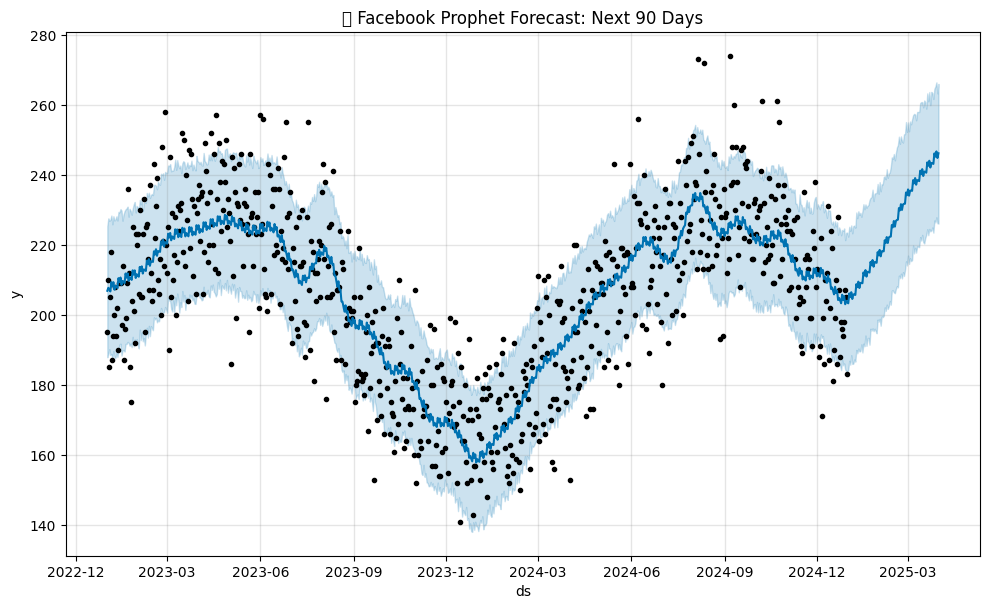

In [4]:
# Prepare format
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Sales': 'y'})

# Build and fit the model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)

# Forecast next 90 days
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

# Plot forecast
fig1 = prophet_model.plot(forecast)
plt.title('📈 Facebook Prophet Forecast: Next 90 Days')
plt.show()


In [5]:
# Automatically find the best ARIMA model
arima_model = pm.auto_arima(df['Sales'], seasonal=True, m=7, stepwise=True, suppress_warnings=True)

# Forecast next 90 days
arima_forecast = arima_model.predict(n_periods=90)

# Create a future date index
future_dates_arima = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')
arima_df = pd.DataFrame({'Date': future_dates_arima, 'Forecast': arima_forecast}).set_index('Date')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<ipython-input-6-ea4843a241d6>:10: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


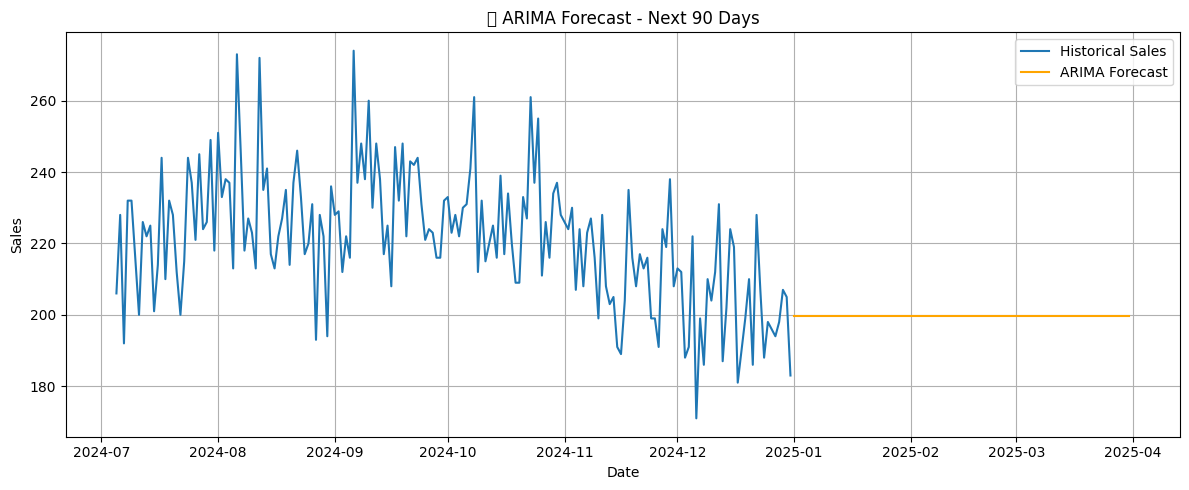

In [6]:
# Plot ARIMA forecast
plt.figure(figsize=(12, 5))
plt.plot(df[-180:], label='Historical Sales')
plt.plot(arima_df, label='ARIMA Forecast', color='orange')
plt.title('📉 ARIMA Forecast - Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
